## Read in the appropriate packages

Progress:

Copy Assignment 2 for draft (done)

Mount data to drive (done)

Swap out data for airplane delay (Done)

---Ensure data is differenced (Done)

Create dataframes for delays (x-axis=time, y-axis=#of delays) (Done)

---Time axis will be MM-DD-YYYY (Done)

---Total up # of delays if dataset does not have it, convert to ints and round down (Done)

Designate Backtesting Periods (Period=12Months, #ofPeriods=4) (Done)

---Period 1 (24-25)

---Period 2 (23-24)

---Period 3 (22-23)

---Period 4 (21-22)

Initialized seasonal auto arima models 1-4 (Done)

Plotted arima models' forecasts (Done)


In [82]:
#Uncomment these 3 lines, run the cell
#Should get 3 warnings to restart session, wait until all warnings
#restart session then comment out these lines


#!pip install --upgrade pip setuptools wheel
#!pip install --force-reinstall pmdarima==2.0.4
#!pip install --force-reinstall numpy==1.26.4


In [83]:
from pandas_datareader import data as pdr #read data from yahoo finance api
import matplotlib.pyplot as plt #viz #GUI manager
import seaborn as sns #viz #plotly is another package
import datetime
import pandas as pd
import numpy as np
from pandas import Grouper #groupby
#statistical data exploration, conducting statistical tests, and estimation of different statistical models
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #autocorrelation plot
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from pandas.plotting import autocorrelation_plot #autocorrelation plot
from statsmodels.graphics.gofplots import qqplot #residual diagnostics
from sklearn.metrics import mean_squared_error #accuracy metrics
from math import sqrt
from sklearn.metrics import mean_absolute_error #accuracy metrics

from random import gauss #create gaussian white noise
from random import seed
from pandas import Series

from statsmodels.tsa.stattools import adfuller # Augmented Dickey Fuller test for testing stationarity

from statsmodels.tsa.arima_model import ARIMA #for manual ARIMA
import pmdarima as pm #auto arima

## 1. Read in the Airline Delay Cause dataset

In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
# Load the new dataset
airline_data_new = pd.read_csv('/content/drive/MyDrive/Airline_Delay_Cause.csv')

# Create a 'date' column by combining 'Year' and 'Month'
airline_data_new['date'] = pd.to_datetime(airline_data_new['year'].astype(str) + '-' + airline_data_new['month'].astype(str) + '-01')

# Set the 'date' column as the index and select the 'arr_del15' column as a DataFrame
airline_delay_df = airline_data_new.set_index('date')[['arr_del15']]

# Rename the column
airline_delay_df.columns = ['value']

# Display the first few rows of the new DataFrame
display(airline_delay_df.head())

,value
date,
2025-06-01,26.0
2025-06-01,1.0
2025-06-01,23.0
2025-06-01,43.0
2025-06-01,29.0


In [86]:
# Aggregate the data by date, summing the 'value' for each date
airline_delay_df = airline_delay_df.groupby('date')['value'].sum().to_frame()

# Display the first few rows of the aggregated DataFrame
display(airline_delay_df.head())

,value
date,
2015-01-01,95951.0
2015-02-01,95179.0
2015-03-01,95452.0
2015-04-01,82247.0
2015-05-01,89645.0


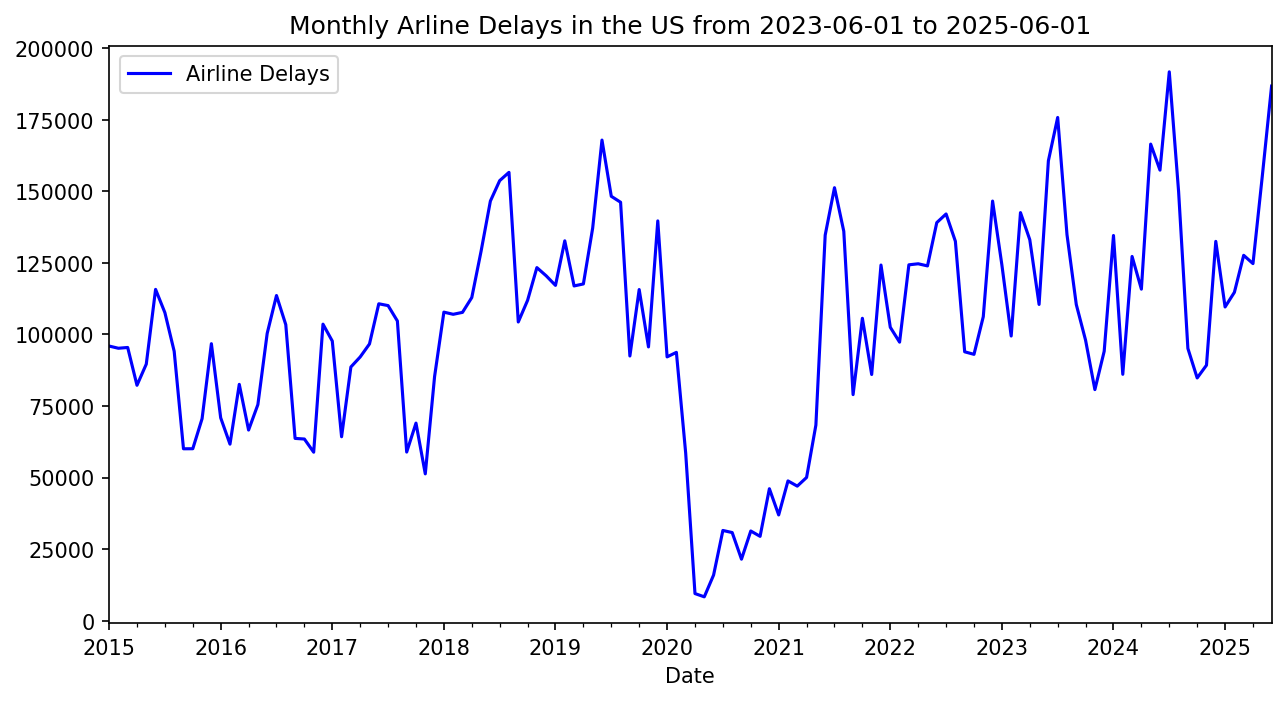

In [87]:
# Visualizing the series

# to set the plot size
plt.figure(figsize=(10, 5), dpi=150) #dpi = resolution. default 100.

# in plot method we set the label and color of the curve.
airline_delay_df['value'].plot(label='Airline Delays', color='Blue')

# adding title to the plot
plt.title('Monthly Arline Delays in the US from {} to {}'.format('2023-06-01', '2025-06-01')) #CHANGE DATES

# adding Label to the x-axis
plt.xlabel('Date')

# adding legend to the curve
plt.legend()


In [88]:
airline_delay_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 126 entries, 2015-01-01 to 2025-06-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   126 non-null    float64
dtypes: float64(1)
memory usage: 2.0 KB


## 2. Exploratory Data Analysis (EDA)


In [89]:
# 1. Descriptive Statistics
airline_delay_df.describe()

,value
count,126.000000
mean,101935.698413
std,37531.486977
min,8339.000000
25%,82327.500000
50%,103975.000000
75%,126623.250000
max,191746.000000


<Axes: >

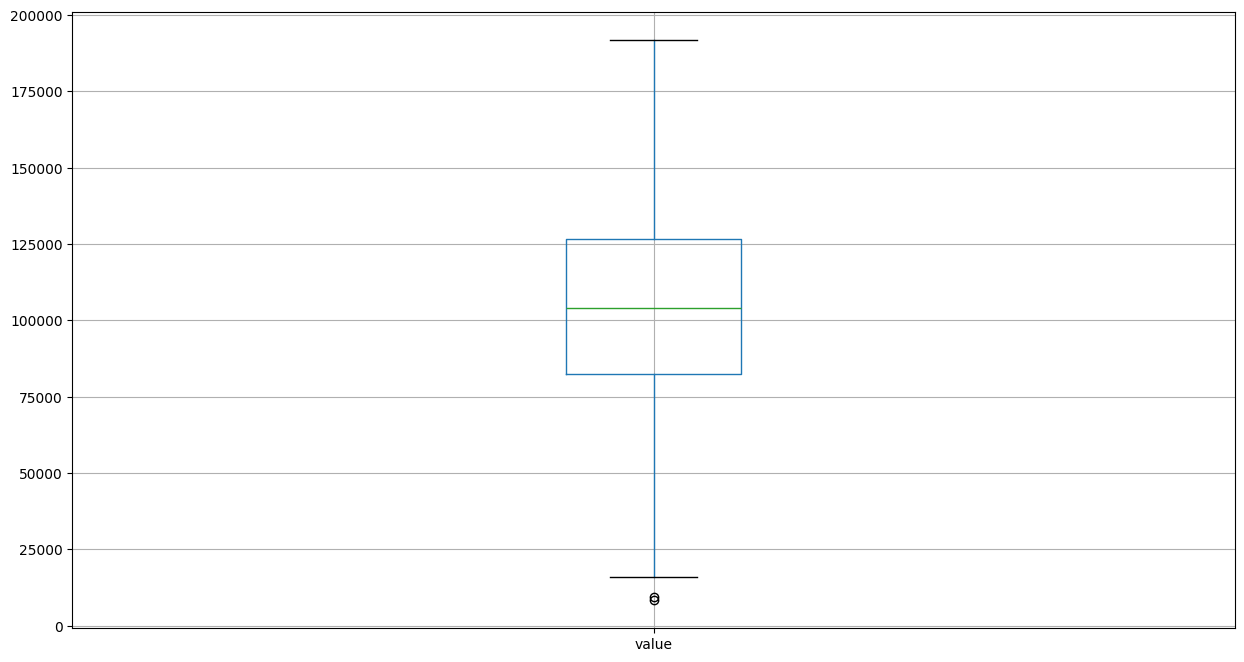

In [90]:
plt.figure(figsize=(15,8))
airline_delay_df.boxplot()

In [91]:
# ask students - why do people look at distributions of data? Slide 11

In [92]:
# 2. Check for missing values
airline_delay_df.isnull().sum()

,0
value,0


In [93]:
# 3. Find the indexes that are missing
pd.date_range(start = airline_delay_df.index.min(), end = airline_delay_df.index.max(), freq='MS').difference(airline_delay_df.index)


DatetimeIndex([], dtype='datetime64[ns]', freq='MS')

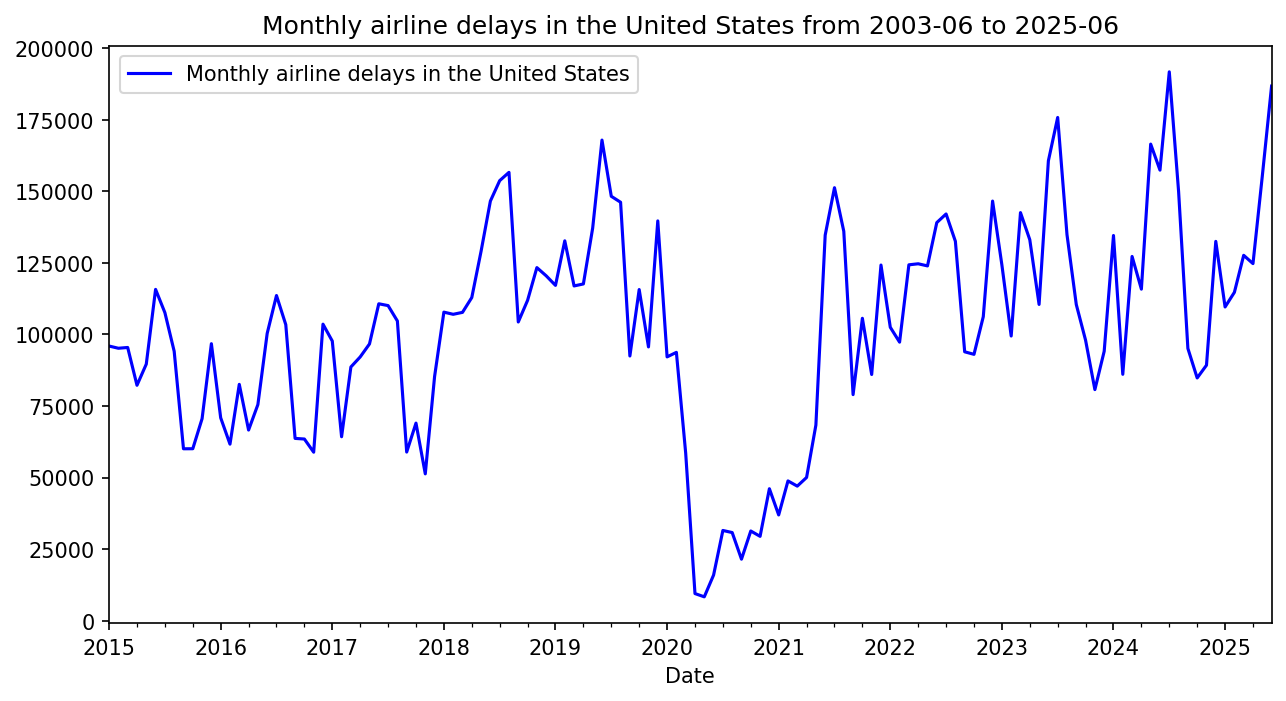

In [94]:
# Visualizing the series

# to set the plot size
plt.figure(figsize=(10, 5), dpi=150) #dpi = resolution. default 100.

# in plot method we set the label and color of the curve.
airline_delay_df['value'].plot(label='Monthly airline delays in the United States', color='blue')

# adding title to the plot
plt.title('Monthly airline delays in the United States from {} to {}'.format('2003-06', '2025-06'))

# adding Label to the x-axis
plt.xlabel('Date')

# adding legend to the curve
plt.legend()


## Stationarity  

### Why Does Stationarity Matter in Time Series Analysis? Why do we have to make sure our data set is stationary before we can run different ARIMA models on it?

Stationarity is crucial in time series analysis because it ensures that the statistical properties of a time series remain constant over time. By removing trends and seasonality, stationarity allows us to focus on the underlying dynamics and capture autocorrelation effectively. ARIMA models assume stationarity and rely on it to make reliable predictions. Ensuring stationarity before applying ARIMA models is necessary to meet model assumptions and obtain accurate results.

1. Consider the forecasting problem. How do you forecast? If everything's different tomorrow then it's impossible to forecast, because everything's going to be different. So the key to forecasting is to find something that will be the same tomorrow, and extend that to tomorrow. Hence, a stationarized series is relatively easy to predict.

2. Statistical modeling methods assume or require the time series to be stationary to be effective. The ARIMA models predict that the mean and variance will be the same in the future as they have been in the past. A stationary time series will also allow us to obtain meaningful statistics such as means, variances, and correlations with other variables. These stats are only useful descriptors if the series is stationary.

3. As in the case of the monthly anti-diabetic drug sales, the series is consistently increasing over time. Hence, the sample mean and variance will grow with the size of the sample and the models will always underestimate the mean and variance in the future periods.

Ssource: https://towardsdatascience.com/why-does-stationarity-matter-in-time-series-analysis-e2fb7be74454

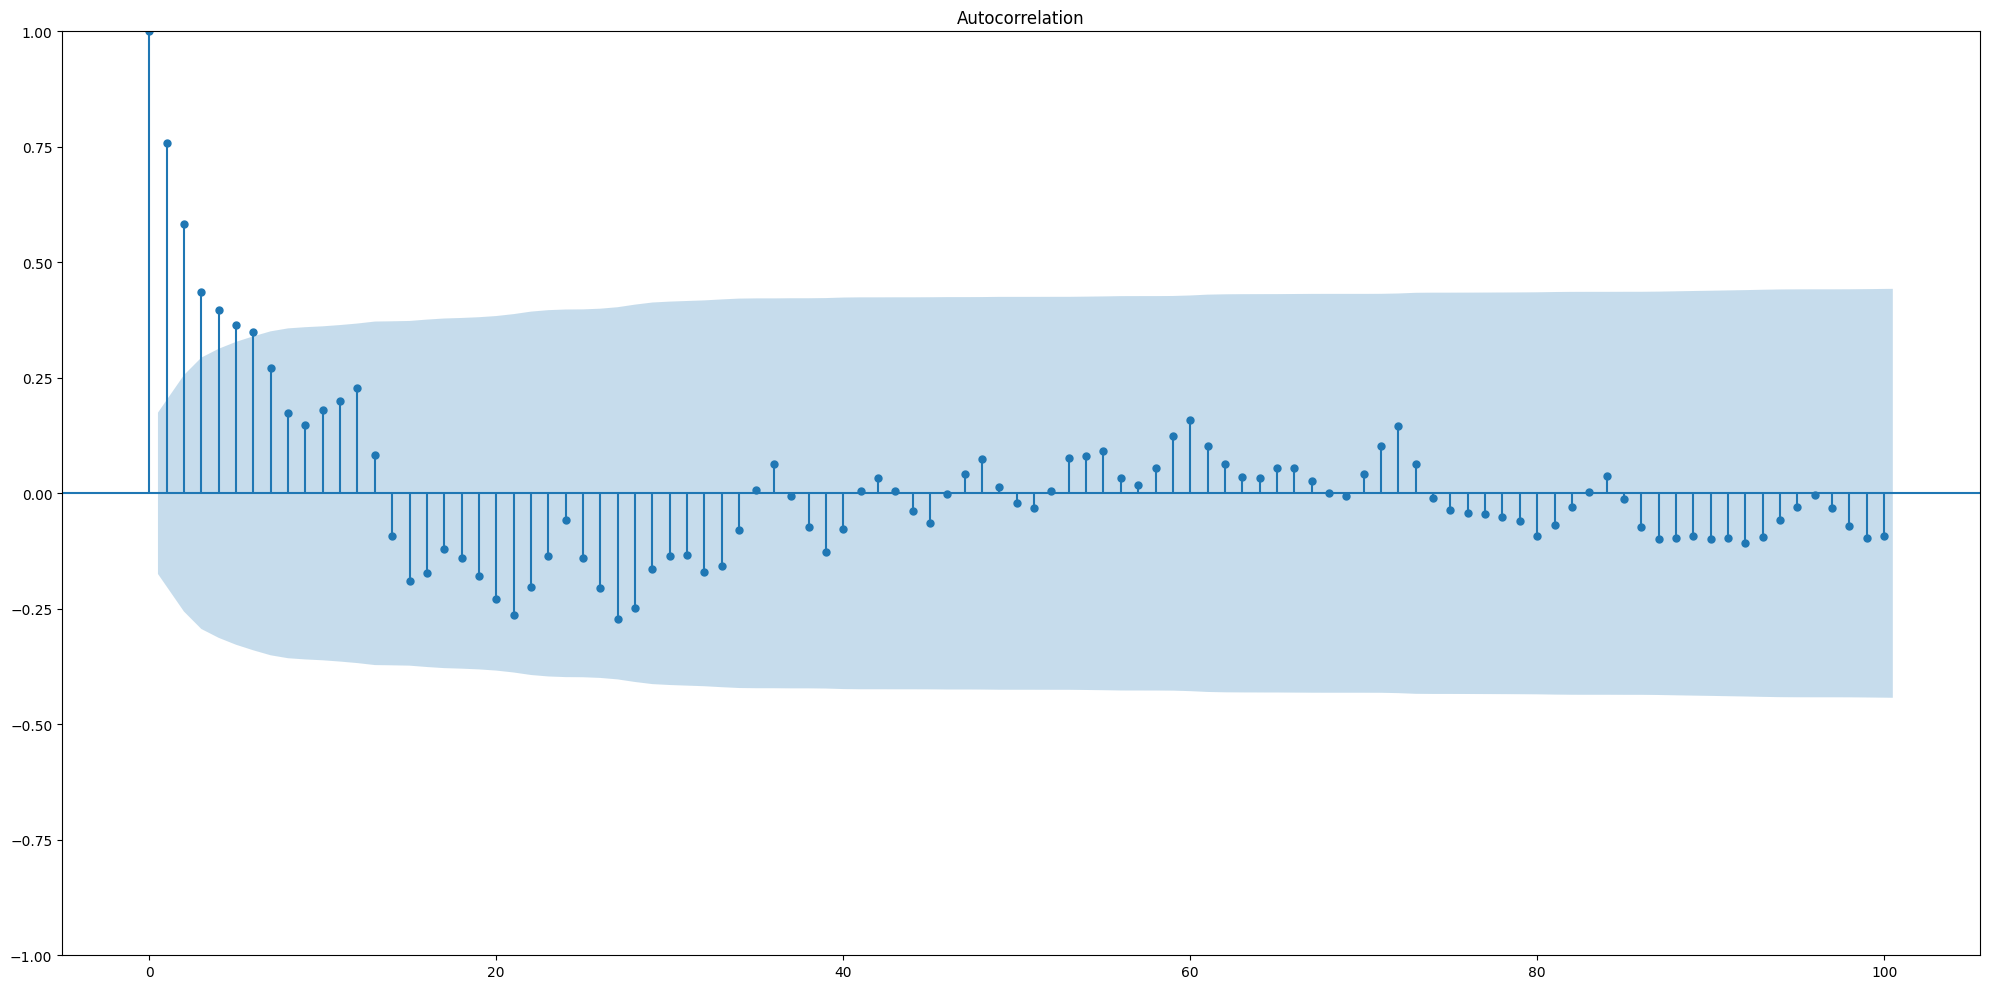

In [95]:
#check if the data is stationary

# autocorrelation plot of the dataset
fig = plot_acf(airline_delay_df, lags=100)
fig.set_size_inches((20, 10))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [96]:
#data has trend as well as seasonlity of 12 months

In [97]:
### Another example of stationary series (sine wave) vs white noise

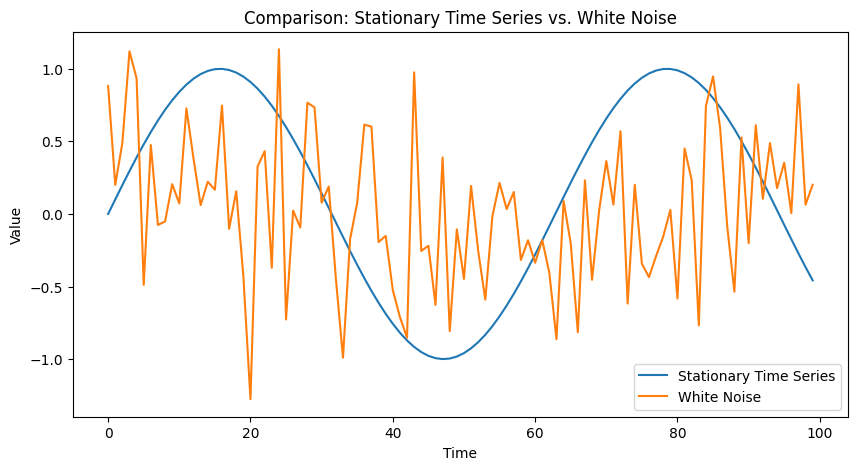

In [98]:
# Set seed for reproducibility
np.random.seed(0)

# Generate a stationary time series
time = np.arange(0, 100)
stationary_ts = np.sin(0.1 * time)

# Generate white noise
white_noise = np.random.normal(0, 0.5, size=100)

# Plot the stationary time series and white noise
plt.figure(figsize=(10, 5))
plt.plot(time, stationary_ts, label='Stationary Time Series')
plt.plot(time, white_noise, label='White Noise')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison: Stationary Time Series vs. White Noise')
plt.legend()
plt.show()

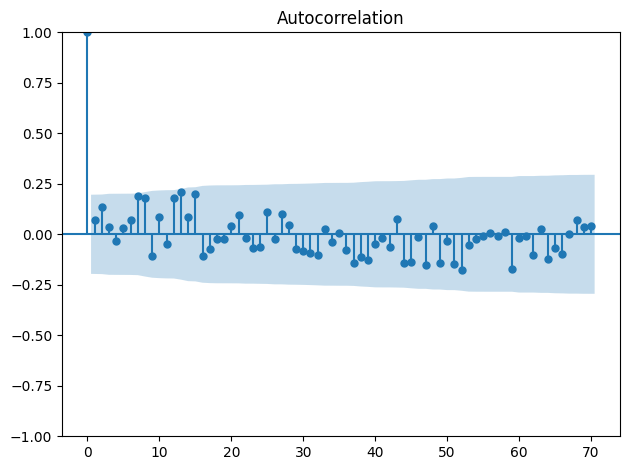

In [99]:
fig = plot_acf(white_noise, lags=70)
# Tight layout to realign things
fig.tight_layout()
plt.show()

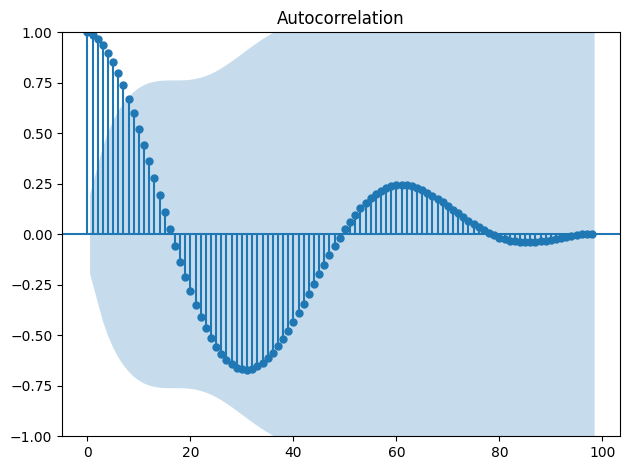

In [100]:
fig = plot_acf(stationary_ts, lags=98)
# Tight layout to realign things
fig.tight_layout()
plt.show()



## Unit Root Test - Augmented Dickey-Fuller (ADF) statistical test to check stationarity

In [101]:
result = adfuller(stationary_ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -547557190348913.187500
p-value: 0.000000
Critical Values:
	1%: -3.502
	5%: -2.893
	10%: -2.583



A sine wave is considered stationary despite its seasonality because the statistical properties of the time series remain constant over time. Although it exhibits a periodic pattern, the mean, variance, and autocovariance of the sine wave do not change, satisfying the definition of stationarity. Stationarity and seasonality are separate concepts, and a time series can be stationary while still displaying seasonality.

In [102]:
# let's check it for our time series

In [103]:
X = airline_delay_df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.120018
p-value: 0.025107
Critical Values:
	1%: -3.490
	5%: -2.888
	10%: -2.581


Running the test prints the test statistic value of 3.14. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset). As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of 3.14 is greater than the value of -2.87 at 5%. Also, the p-value is greater than 0.05.

This suggests that we fail to reject the null hypothesis with a significance level of 5%. Failing to reject the null hypothesis means that the process a unit root, and in turn that the time series is non-stationary.

## Differencing

One of the best ways to make a non-stationary time series stationary — compute the differences between consecutive observations. This is known as differencing.

Transformations such as logarithms can help to stabilise the variance of a time series. Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.

<Axes: xlabel='date'>

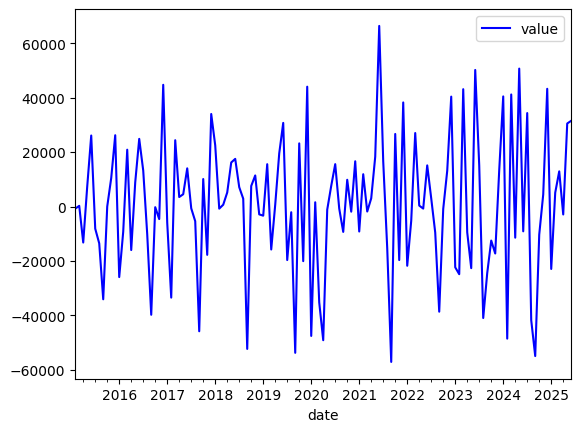

In [104]:
#create differenced dataset
first_diff_df = airline_delay_df.diff().dropna()
first_diff_df.plot(color='blue')

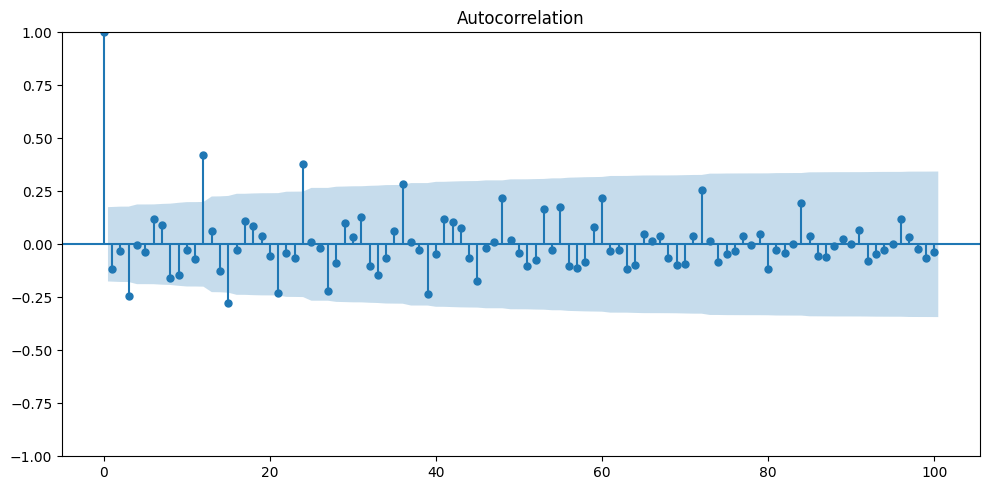

In [105]:
# autocorrelation plot of differenced dataset
fig = plot_acf(first_diff_df, lags=100)
fig.set_size_inches((10, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [106]:
X = first_diff_df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.689877
p-value: 0.075806
Critical Values:
	1%: -3.491
	5%: -2.888
	10%: -2.581


From the ACF and line plot and the ADF test p-value we can deduce that the series is non-stationary. As we can see a seasonal pattern, let us apply seasonal differencing.

<Axes: xlabel='date'>

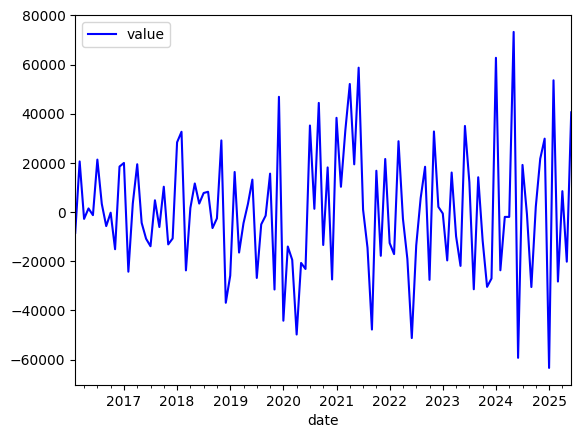

In [107]:
seasonal_diff_df = first_diff_df.diff(12).dropna()
seasonal_diff_df.plot(color = 'blue')

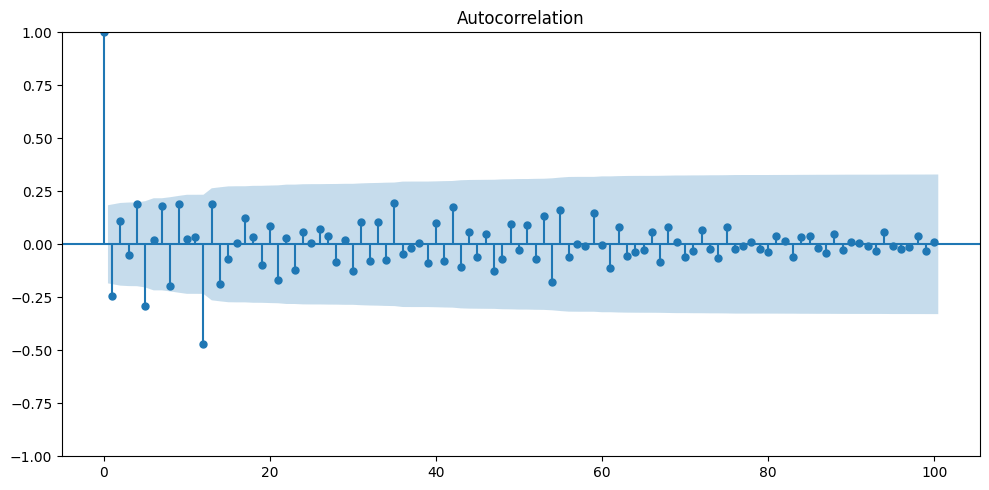

In [108]:
# autocorrelation plot of the seasonaly differenced dataset
fig = plot_acf(seasonal_diff_df, lags=100)
fig.set_size_inches((10, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [109]:
X = seasonal_diff_df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.370613
p-value: 0.000334
Critical Values:
	1%: -3.497
	5%: -2.891
	10%: -2.582


Since p-value is less than 0.05 we can reject the null hypothesis and the data is stationary.

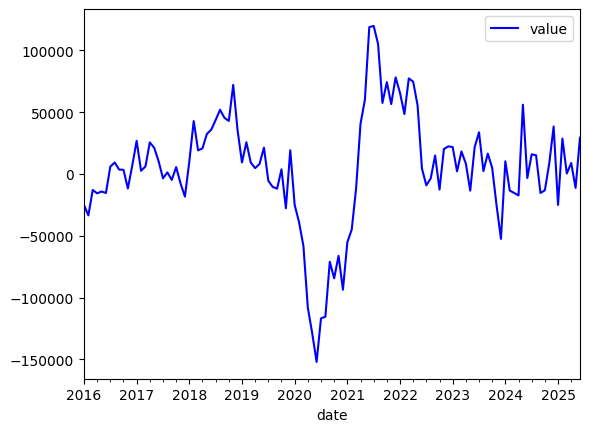

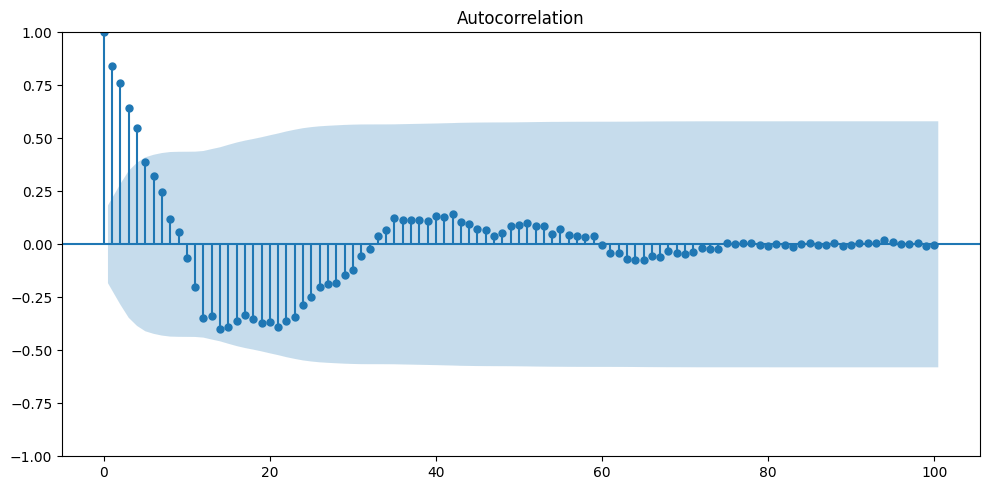

ADF Statistic: -2.500625
p-value: 0.115322
Critical Values:
	1%: -3.497
	5%: -2.891
	10%: -2.582


In [110]:
#lets see what woul've happened if we seasonally differeced first
seasnl_diff_df = airline_delay_df.diff(12).dropna()
seasnl_diff_df.plot(color='blue')

fig = plot_acf(seasnl_diff_df, lags=100)
fig.set_size_inches((10, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

X = seasnl_diff_df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

## Seasonal differencing and interpretation of differencing

When both seasonal and first differences are applied -
1. it makes no difference which is done first—the result will be the same.
2. If seasonality is strong, it is recommended that seasonal differencing be done first because sometimes the resulting series will be stationary and there will be no need for further first difference.

Also, it is important that if differencing is used, the differences are interpretable.
1. first differences are the change between one observation and the next.
2. seasonal differences are the change between one year to the next.

But taking lag 3 differences for yearly data, for example, results in a model which cannot be sensibly interpreted.


# Forecasting

In [111]:
airline_delay_df

,value
date,
2015-01-01,95951.0
2015-02-01,95179.0
2015-03-01,95452.0
2015-04-01,82247.0
2015-05-01,89645.0
...,...
2025-02-01,114715.0
2025-03-01,127648.0
2025-04-01,124749.0


In [112]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(airline_delay_df, test_size=12, random_state=25, shuffle = False)
#shuffle = False is very important to ensure the order of the data

print(f"No. of training examples: {train_data.shape[0]}")
print(f"No. of testing examples: {test_data.shape[0]}")

No. of training examples: 114
No. of testing examples: 12


In [113]:
train_data

,value
date,
2015-01-01,95951.0
2015-02-01,95179.0
2015-03-01,95452.0
2015-04-01,82247.0
2015-05-01,89645.0
...,...
2024-02-01,86079.0
2024-03-01,127248.0
2024-04-01,115828.0


In [114]:
test_data

,value
date,
2024-07-01,191746.0
2024-08-01,150010.0
2024-09-01,95112.0
2024-10-01,84806.0
2024-11-01,89260.0
2024-12-01,132515.0
2025-01-01,109605.0
2025-02-01,114715.0
2025-03-01,127648.0


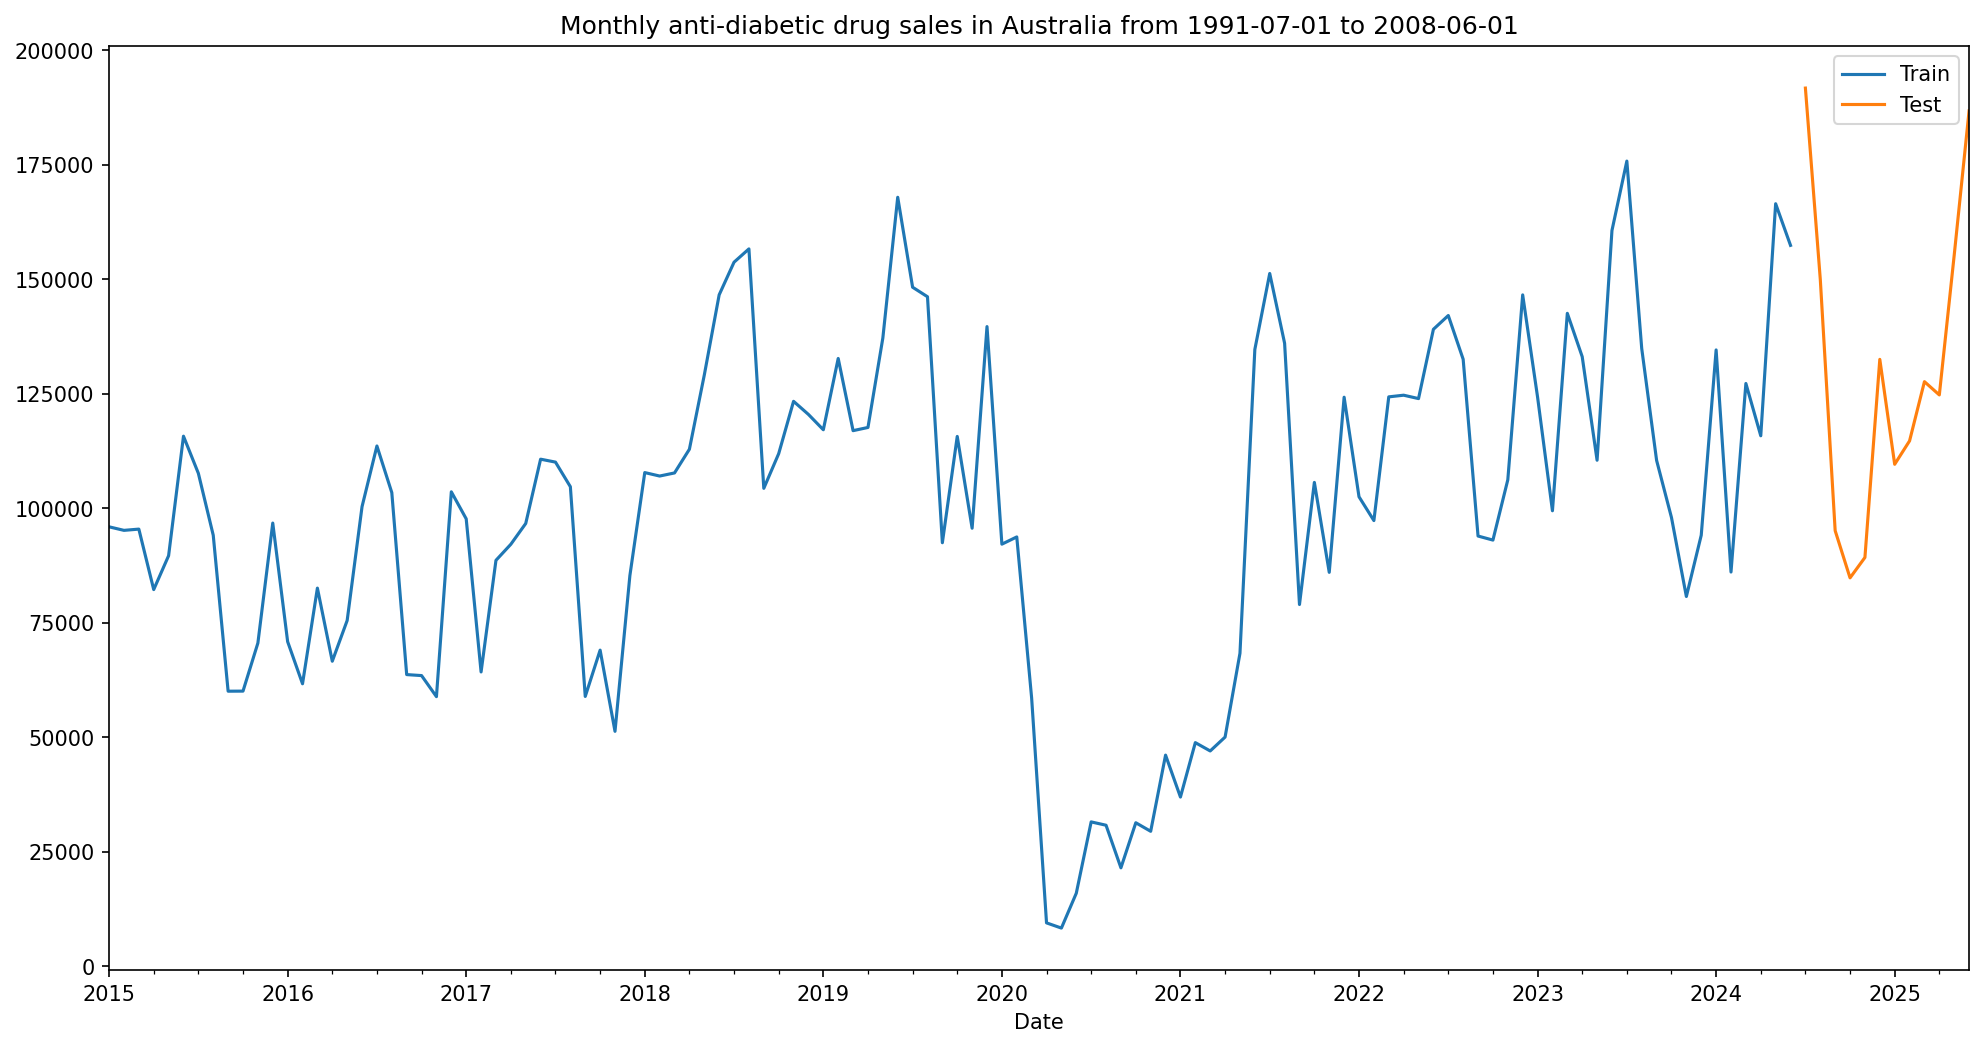

In [115]:
#Plot train and test data

# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)

# using plot method to plot close prices.
# in plot method we set the label and color of the curve.
train_data['value'].plot(label='Train')
test_data['value'].plot(label='Test')

plt.title('Monthly anti-diabetic drug sales in Australia from {} to {}'.format('1991-07-01', '2008-06-01'))

# adding Label to the x-axis
plt.xlabel('Date')

# adding legend to the curve
plt.legend()


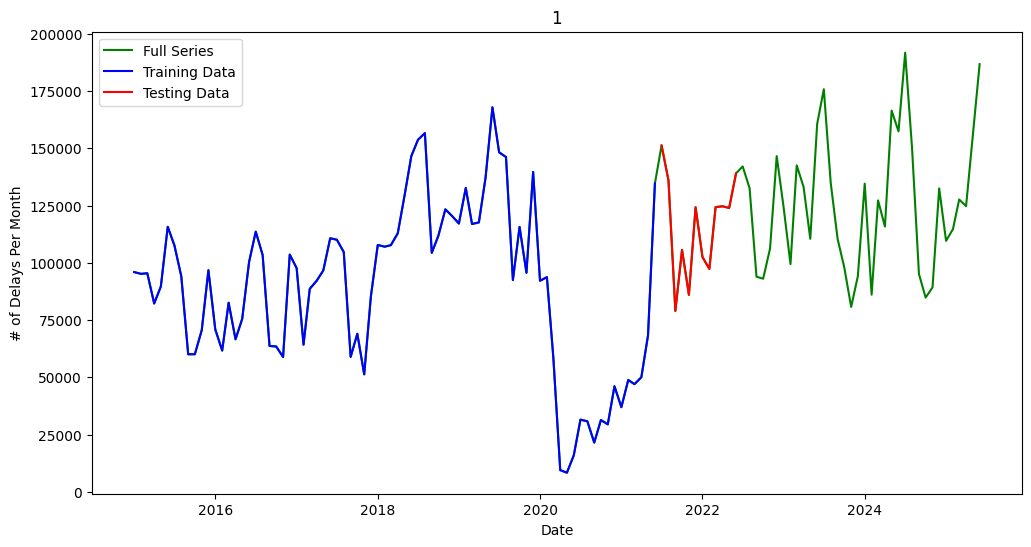

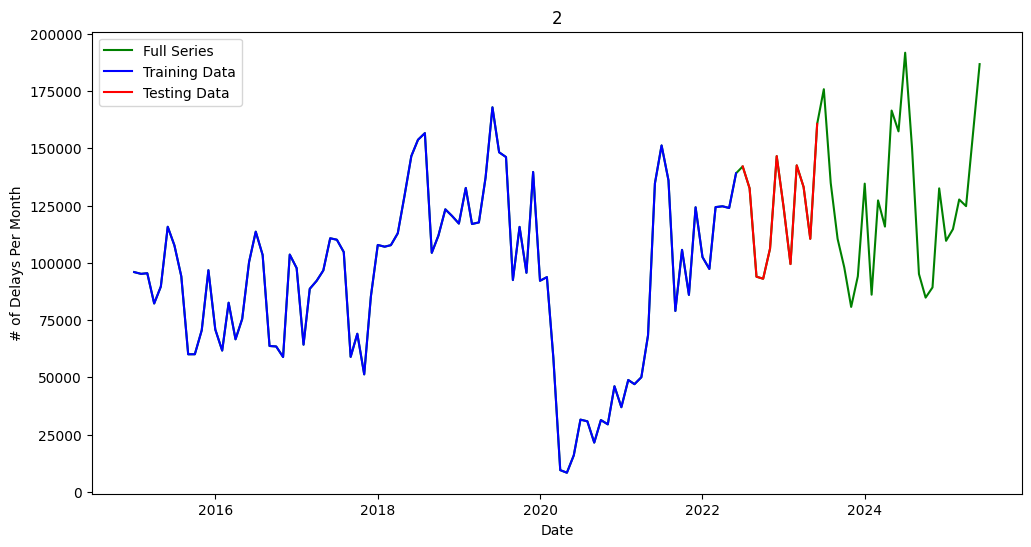

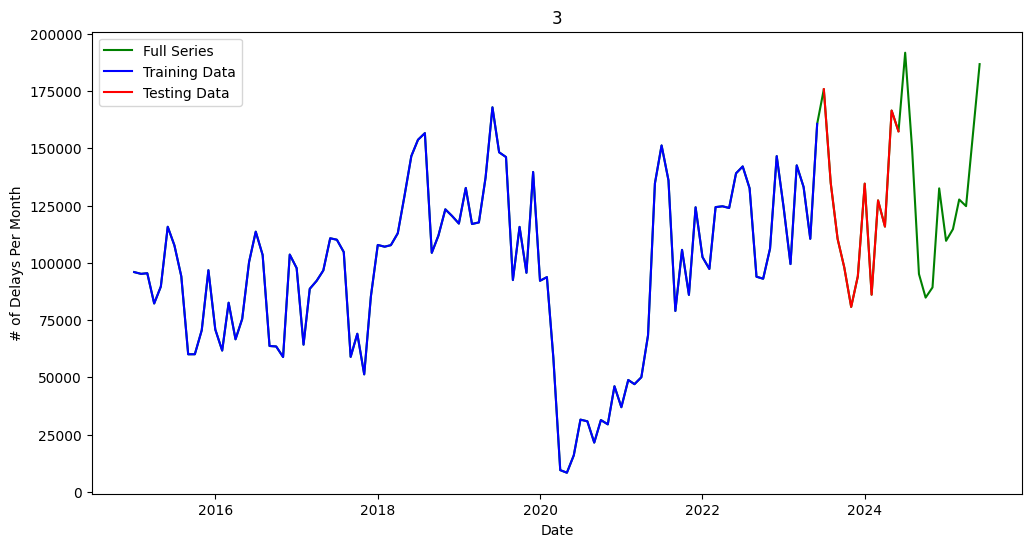

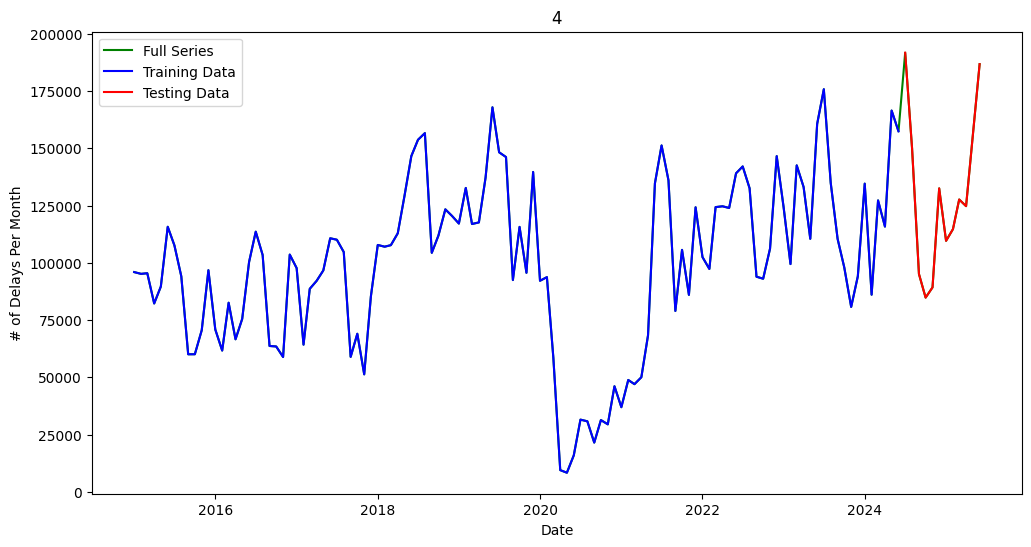

In [116]:
# AMY: train-test split 4 periods
splits = [
    ('2003-06-01','2021-06-01','2021-07-01', '2022-06-01'),
    ('2003-06-01', '2022-06-01', '2022-07-01', '2023-06-01'),
    ('2003-06-01', '2023-06-01', '2023-07-01', '2024-06-01'),
    ('2003-06-01', '2024-06-01', '2024-07-01', '2025-06-01')
]
data_splits = {}
for window, (train_start, train_end, test_start, test_end) in enumerate(splits,
                                                                        1):
    train = airline_delay_df.loc[train_start:train_end]
    test = airline_delay_df.loc[test_start:test_end]

    data_splits[window] = {
                          "train": train,
                          "test": test
                          }

    plt.figure(figsize=(12,6))
    plt.plot(airline_delay_df.index, airline_delay_df['value'], color='green', label='Full Series')
    plt.plot(train.index, train['value'], color='blue', label='Training Data')
    plt.plot(test.index, test['value'], color='red', label='Testing Data')
    plt.title(f'{window}')
    plt.xlabel('Date')
    plt.ylabel('# of Delays Per Month')
    plt.legend()
    plt.show()

In [117]:
# Seasonal - fit stepwise auto-ARIMA for window 1
arima_1 = pm.auto_arima(data_splits[1]['train'], start_p=0, start_q=0,
                        test='adf',
                        max_p=3, max_q=3,
                        m=12,
                        d=None,
                        D=1,
                        seasonal=True,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,1,1)[12]             : AIC=inf, Time=0.99 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=1513.414, Time=0.03 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,0)(1,1,0)[12]             : AIC=1487.076, Time=0.25 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,1)(0,1,1)[12]             : AIC=1461.087, Time=0.37 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=1472.714, Time=0.20 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,1)(1,1,1)[12]             : AIC=1462.913, Time=0.56 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,1)(0,1,2)[12]             : AIC=1462.781, Time=0.45 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AIC=1466.924, Time=0.19 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,1)(1,1,2)[12]             : AIC=1464.550, Time=0.76 sec
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=1509.578, Time=0.11 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,1)(0,1,1)[12]             : AIC=1460.632, Time=0.23 sec
 ARIMA(1,2,1)(0,1,0)[12]             : AIC=1473.657, Time=0.07 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,1)(1,1,1)[12]             : AIC=1462.325, Time=0.61 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,1)(0,1,2)[12]             : AIC=1462.090, Time=0.52 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,1)(1,1,0)[12]             : AIC=1467.417, Time=0.21 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,1)(1,1,2)[12]             : AIC=1463.719, Time=0.75 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=1475.970, Time=0.17 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,1)(0,1,1)[12]             : AIC=1462.416, Time=0.32 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,2)(0,1,1)[12]             : AIC=1463.534, Time=0.39 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,2)(0,1,1)[12]             : AIC=1462.594, Time=0.22 sec
 ARIMA(2,2,0)(0,1,1)[12]             : AIC=1469.092, Time=0.15 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,2)(0,1,1)[12]             : AIC=1464.972, Time=0.53 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,1)(0,1,1)[12] intercept   : AIC=1468.723, Time=0.21 sec

Best model:  ARIMA(1,2,1)(0,1,1)[12]          
Total fit time: 8.324 seconds


In [118]:
# Seasonal - fit stepwise auto-ARIMA for window 2
arima_2 = pm.auto_arima(data_splits[2]['train'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3,
                         start_P=0,
                         seasonal=True,
                         d=None,
                         D=1,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

print(arima_2.summary())

Performing stepwise search to minimize aic


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2042.614, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2042.765, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2043.891, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2043.921, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2040.811, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.361 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   90
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1019.405
Date:                Fri, 03 Oct 2025   AIC                           2040.811
Time:                        17:17:13   BIC                           2043.299
Sample:                    01-01-2015   HQIC                          2041.814
                         - 06-01-2022                                         
Covariance Type:                  opg   

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [119]:
# Seasonal - fit stepwise auto-ARIMA for window 3
arima_3 = pm.auto_arima(data_splits[3]['train'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3,
                         m=12,
                         start_P=0,
                         seasonal=True,
                         d=None,
                         D=1,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

print(arima_3.summary())

Performing stepwise search to minimize aic


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2022.138, Time=0.50 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2042.310, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2028.610, Time=0.13 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2020.367, Time=0.16 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2043.400, Time=0.05 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2022.321, Time=0.27 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2022.309, Time=0.49 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2029.108, Time=0.12 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2024.220, Time=0.74 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2020.124, Time=0.13 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,1)[12]             : AIC=2017.889, Time=0.18 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=2024.769, Time=0.10 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,1,1)[12]             : AIC=2019.348, Time=0.60 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=4.43 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,2)[12]             : AIC=2016.505, Time=0.44 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,2)[12]             : AIC=2021.494, Time=0.48 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2024.183, Time=0.53 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=2022.189, Time=0.47 sec

Best model:  ARIMA(0,1,0)(0,1,2)[12]          
Total fit time: 9.898 seconds
                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  102
Model:             SARIMAX(0, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood               -1005.253
Date:                                 Fri, 03 Oct 2025   AIC                           2016.505
Time:                                         17:17:23   BIC                           2023.971
Sample:                                     01-01-2015   HQIC                          2019.515
                                          - 06-01-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------

In [120]:
# Seasonal - fit stepwise auto-ARIMA for window 4
arima_4 = pm.auto_arima(data_splits[4]['train'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3,
                         m=12,
                         start_P=0,
                         seasonal=True,
                         d=None,
                         D=1,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

print(arima_4.summary())

Performing stepwise search to minimize aic


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2307.287, Time=0.92 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2335.025, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2317.900, Time=0.16 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2307.916, Time=0.23 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=2335.842, Time=0.13 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,1)[12]             : AIC=2309.283, Time=0.64 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,2)[12]             : AIC=inf, Time=1.47 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,0)[12]             : AIC=2318.754, Time=0.43 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,2)[12]             : AIC=2311.263, Time=1.87 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,1)[12]             : AIC=2306.678, Time=0.26 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2334.553, Time=0.08 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,1)[12]             : AIC=2308.630, Time=0.41 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,2)[12]             : AIC=inf, Time=1.45 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,2)[12]             : AIC=2310.531, Time=1.64 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2313.636, Time=0.52 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,1,1)[12]             : AIC=2308.654, Time=0.76 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,1,1)[12]             : AIC=2308.682, Time=2.62 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,1)[12] intercept   : AIC=2309.121, Time=0.89 sec

Best model:  ARIMA(1,1,0)(0,1,1)[12]          
Total fit time: 14.621 seconds
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  114
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -1150.339
Date:                              Fri, 03 Oct 2025   AIC                           2306.678
Time:                                      17:17:37   BIC                           2314.524
Sample:                                  01-01-2015   HQIC                          2309.854
                                       - 06-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


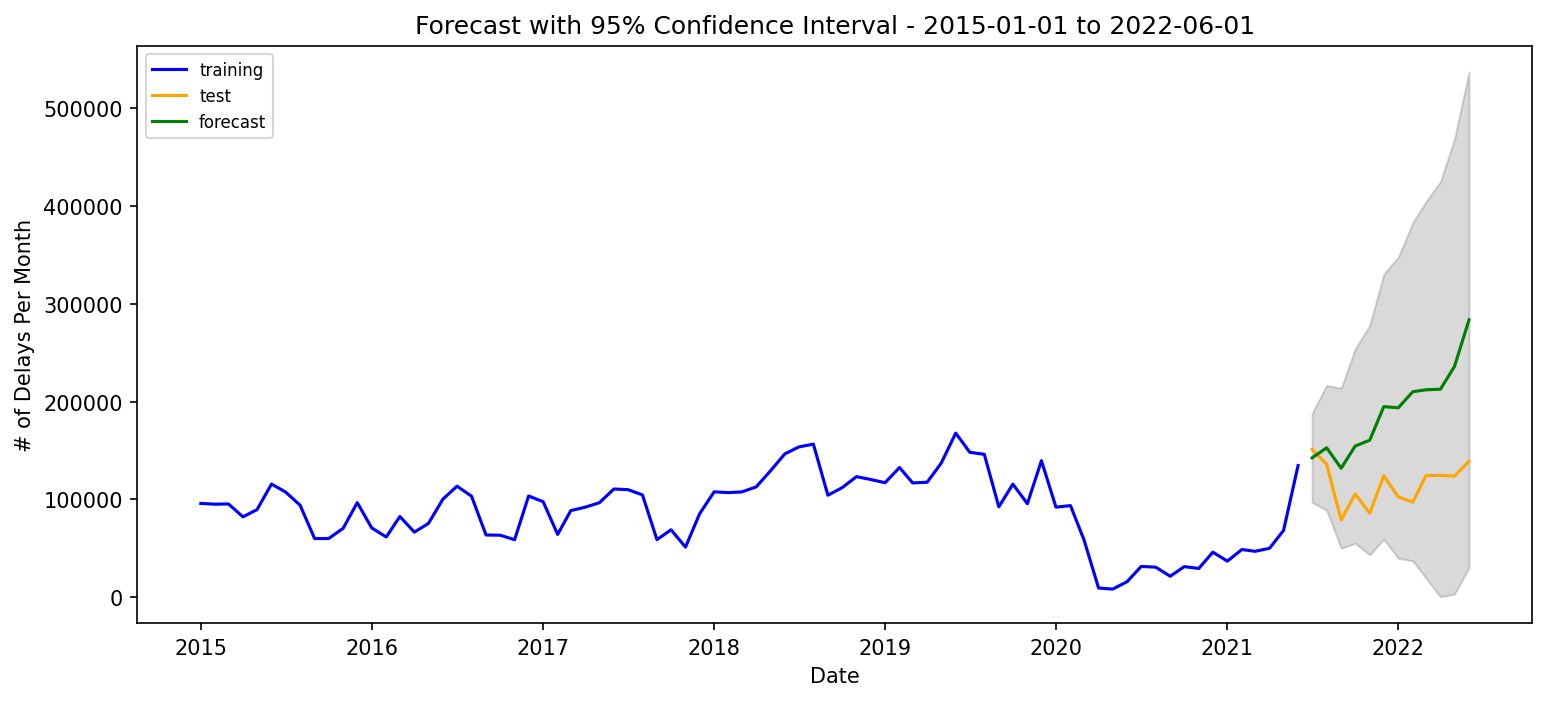

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


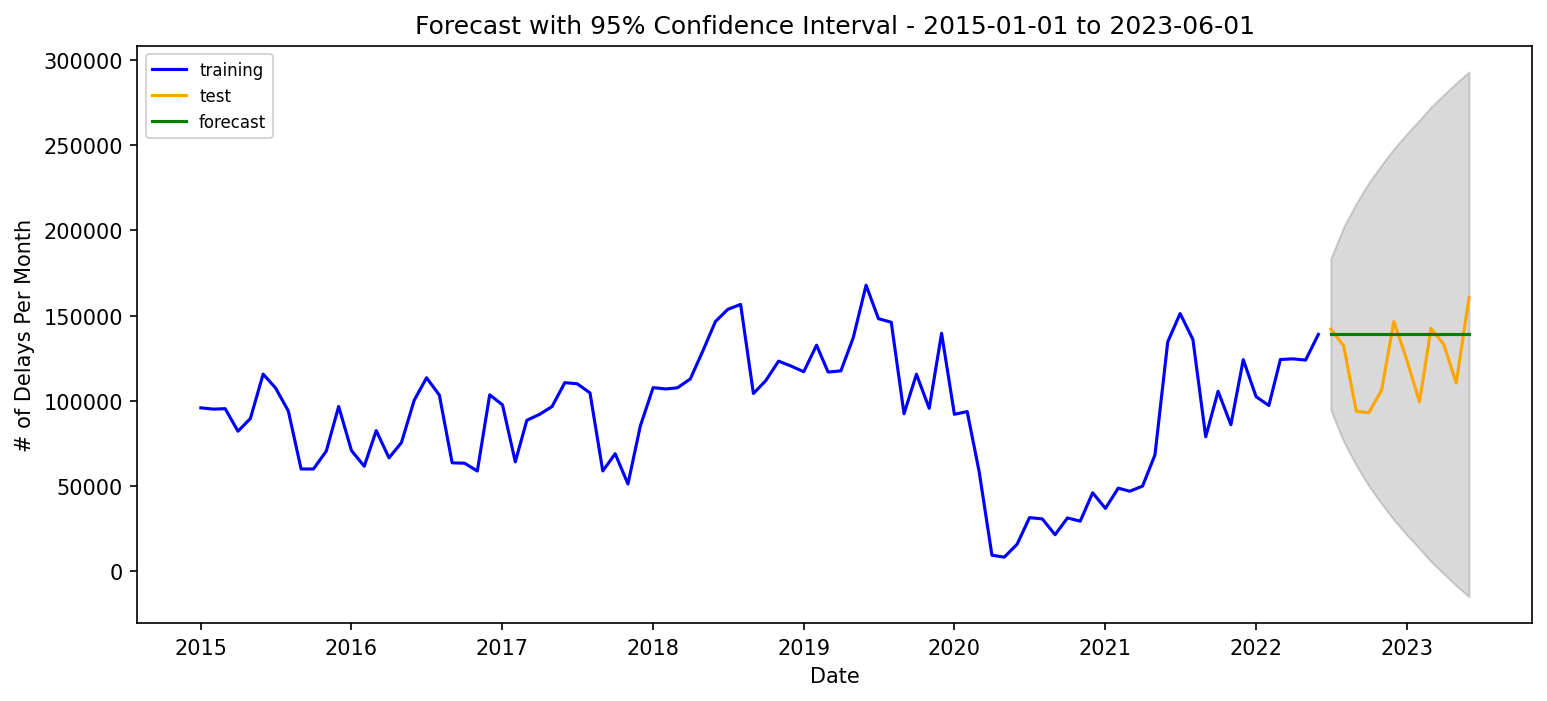

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


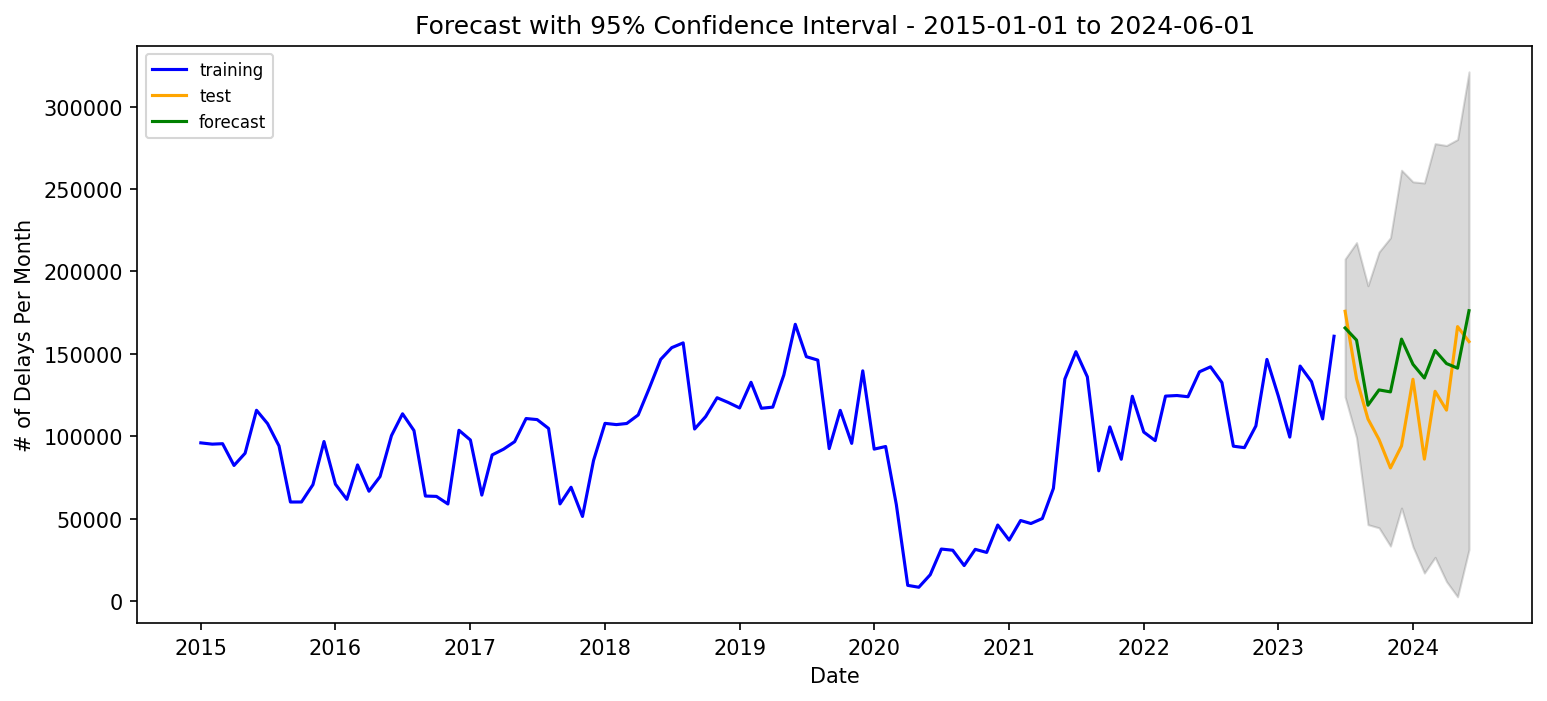

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


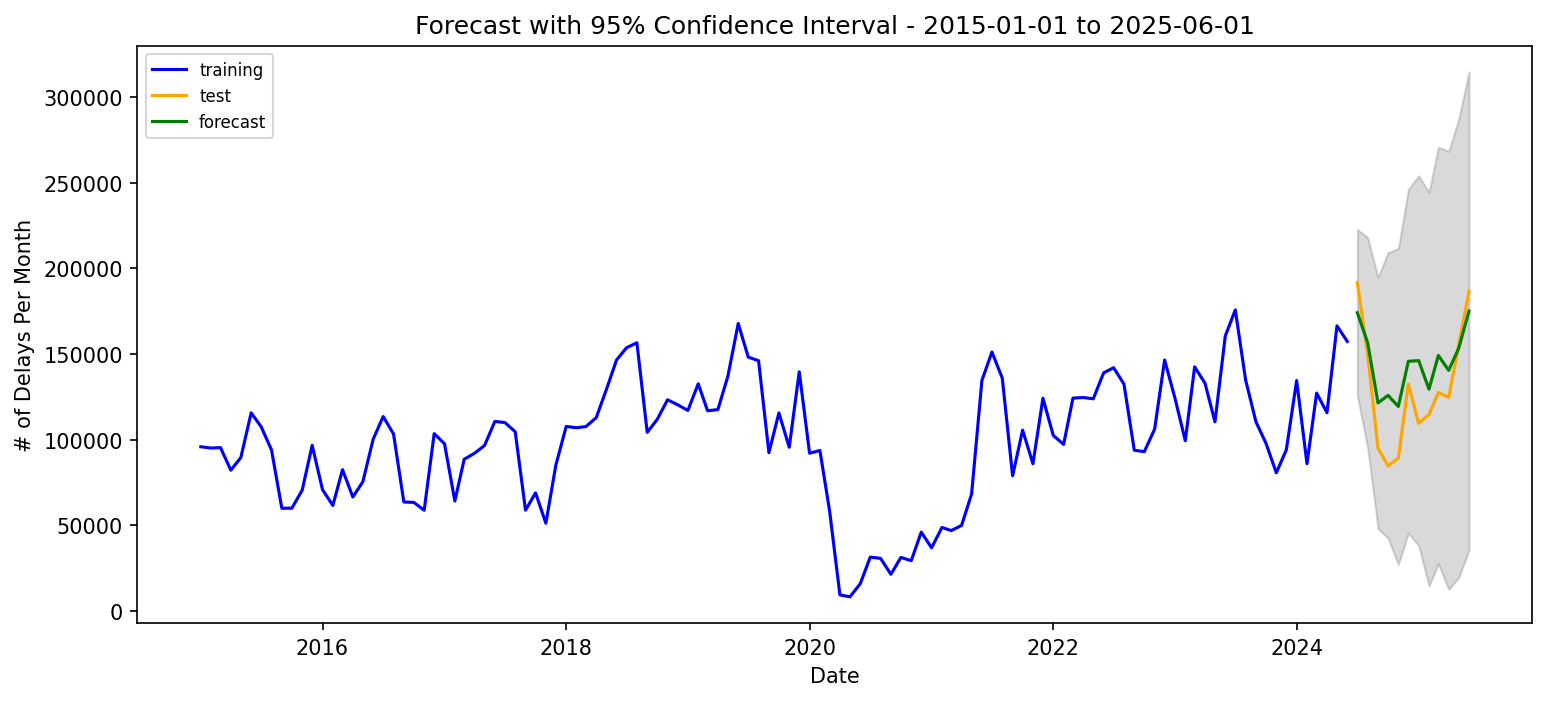

In [121]:
import matplotlib.pyplot as plt
import pandas as pd

arima_models = {1: arima_1, 2: arima_2, 3: arima_3, 4: arima_4}

for window, data in data_splits.items():
    train_data = data['train']
    test_data = data['test']
    model = arima_models[window]

    # Forecast
    n_periods = len(test_data)
    fc_auto_seasonal, confint = model.predict(n_periods=n_periods, return_conf_int=True)

    # make series for plotting purpose
    fc_series_auto_seasonal = pd.Series(fc_auto_seasonal, index=test_data.index)
    lower_series = pd.Series(confint[:, 0], index=test_data.index)
    upper_series = pd.Series(confint[:, 1], index=test_data.index)

    # Plot
    plt.figure(figsize=(12, 5), dpi=150)
    plt.plot(train_data, label='training', color='blue')
    plt.plot(test_data, label='test', color='orange')
    plt.plot(fc_series_auto_seasonal, label='forecast', color='green')
    plt.fill_between(lower_series.index, lower_series, upper_series,
                     color='k', alpha=.15)
    # Get the date range for the title
    date_range_title = f'{train_data.index.min().strftime("%Y-%m-%d")} to {test_data.index.max().strftime("%Y-%m-%d")}'
    plt.title(f'Forecast with 95% Confidence Interval - {date_range_title}') #Using Seasonal Auto ARIMA
    plt.xlabel('Date')
    plt.ylabel('# of Delays Per Month')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()